# Desafio 5

Neste desafio, vamos praticar sobre redução de dimensionalidade com PCA e seleção de variáveis com RFE. Utilizaremos o _data set_ [Fifa 2019](https://www.kaggle.com/karangadiya/fifa19), contendo originalmente 89 variáveis de mais de 18 mil jogadores do _game_ FIFA 2019.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [1]:
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sct
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats as st
from sklearn.decomposition import PCA

from loguru import logger

/home/jonathan/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home/jonathan/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
!pip install loguru


     |████████████████████████████████| 56 kB 137 kB/s eta 0:00:01
You should consider upgrading via the '/home/jonathan/anaconda3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install --upgrade pip

     |████████████████████████████████| 1.5 MB 163 kB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.1
    Uninstalling pip-20.1:
      Successfully uninstalled pip-20.1


In [2]:
# Algumas configurações para o matplotlib.
%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 8)

sns.set()

In [3]:
fifa = pd.read_csv("fifa.csv")

In [4]:
columns_to_drop = ["Unnamed: 0", "ID", "Name", "Photo", "Nationality", "Flag",
                   "Club", "Club Logo", "Value", "Wage", "Special", "Preferred Foot",
                   "International Reputation", "Weak Foot", "Skill Moves", "Work Rate",
                   "Body Type", "Real Face", "Position", "Jersey Number", "Joined",
                   "Loaned From", "Contract Valid Until", "Height", "Weight", "LS",
                   "ST", "RS", "LW", "LF", "CF", "RF", "RW", "LAM", "CAM", "RAM", "LM",
                   "LCM", "CM", "RCM", "RM", "LWB", "LDM", "CDM", "RDM", "RWB", "LB", "LCB",
                   "CB", "RCB", "RB", "Release Clause"
]

try:
    fifa.drop(columns_to_drop, axis=1, inplace=True)
except KeyError:
    logger.warning(f"Columns already dropped")

## Inicia sua análise a partir daqui

In [5]:
df = fifa.copy()
df.head()

,Age,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,31,94,94,84.0,95.0,70.0,90.0,86.0,97.0,93.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,33,94,94,84.0,94.0,89.0,81.0,87.0,88.0,81.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,26,92,93,79.0,87.0,62.0,84.0,84.0,96.0,88.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,27,91,93,17.0,13.0,21.0,50.0,13.0,18.0,21.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,27,91,92,93.0,82.0,55.0,92.0,82.0,86.0,85.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              18207 non-null  int64  
 1   Overall          18207 non-null  int64  
 2   Potential        18207 non-null  int64  
 3   Crossing         18159 non-null  float64
 4   Finishing        18159 non-null  float64
 5   HeadingAccuracy  18159 non-null  float64
 6   ShortPassing     18159 non-null  float64
 7   Volleys          18159 non-null  float64
 8   Dribbling        18159 non-null  float64
 9   Curve            18159 non-null  float64
 10  FKAccuracy       18159 non-null  float64
 11  LongPassing      18159 non-null  float64
 12  BallControl      18159 non-null  float64
 13  Acceleration     18159 non-null  float64
 14  SprintSpeed      18159 non-null  float64
 15  Agility          18159 non-null  float64
 16  Reactions        18159 non-null  float64
 17  Balance     

In [7]:
df.describe()

,Age,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
count,18207.000000,18207.000000,18207.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,...,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000,18159.000000
mean,25.122206,66.238699,71.307299,49.734181,45.550911,52.298144,58.686712,42.909026,55.371001,47.170824,...,48.548598,58.648274,47.281623,47.697836,45.661435,16.616223,16.391596,16.232061,16.388898,16.710887
std,4.669943,6.908930,6.136496,18.364524,19.525820,17.379909,14.699495,17.694408,18.910371,18.395264,...,15.704053,11.436133,19.904397,21.664004,21.289135,17.695349,16.906900,16.502864,17.034669,17.955119
min,16.000000,46.000000,48.000000,5.000000,2.000000,4.000000,7.000000,4.000000,4.000000,6.000000,...,5.000000,3.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,21.000000,62.000000,67.000000,38.000000,30.000000,44.000000,54.000000,30.000000,49.000000,34.000000,...,39.000000,51.000000,30.000000,27.000000,24.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,25.000000,66.000000,71.000000,54.000000,49.000000,56.000000,62.000000,44.000000,61.000000,48.000000,...,49.000000,60.000000,53.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,28.000000,71.000000,75.000000,64.000000,62.000000,64.000000,68.000000,57.000000,68.000000,62.000000,...,60.000000,67.000000,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,45.000000,94.000000,95.000000,93.000000,95.000000,94.000000,93.000000,90.000000,97.000000,94.000000,...,92.000000,96.000000,94.000000,93.000000,91.000000,90.000000,92.000000,91.000000,90.000000,94.000000


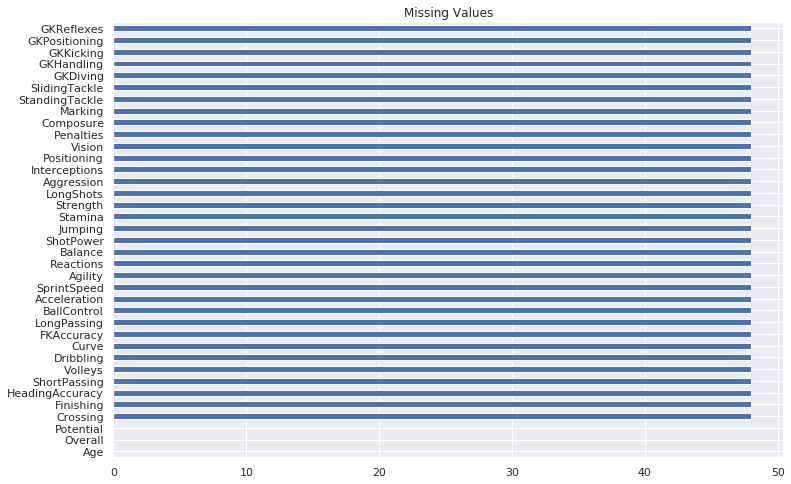

In [8]:
plt.title('Missing Values')
df.isnull().sum().plot(kind = 'barh')

In [10]:
#Drop missing values
df.dropna(inplace = True)

In [11]:
df.head()

,Age,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,31,94,94,84.0,95.0,70.0,90.0,86.0,97.0,93.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,33,94,94,84.0,94.0,89.0,81.0,87.0,88.0,81.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,26,92,93,79.0,87.0,62.0,84.0,84.0,96.0,88.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,27,91,93,17.0,13.0,21.0,50.0,13.0,18.0,21.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,27,91,92,93.0,82.0,55.0,92.0,82.0,86.0,85.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


# Normalizar ou Padronizar os dados ? 

Essa é uma pergunta super comum que fazemos quando vamos aplicar PCA nos nossos dados. Para ter uma resposta bem respaldada, devemos analisar os fundamentos por trás do algoritmo. Vamos primeiramente entender o que é normalização e sua diferença para a padronização (standardzation). Em seguinda, iremos verificar as implicações gerada pelos processos nos nossos dados para então decidir se devemos ou não aplicar alguma dessas duas técnicas.

## Centralizar os dados

Centralizar os dados é, nada mais, nada menos do que subtrair cada valor de uma determinada variável por uma constante - na maioria das vezes sua média. Essa técnica basicamente redefine o ponto zero da variável e é deterinado através do valor que é usado na subtração. 

Qando centralizamos as nossas variáveis através da subtração de cada valor pela sua média amostral , estamos na verdade realizando uma transformação de forma que essa feature tenha uma média igual a zero.

Em outras palavras, podemos considerar essa transformação como a variação que a variável possui com relação a sua média. 

Para o nosso caso em particular, como estamos prestes a aplicar PCA nos nossos dados, é importante dizer que a aplicação desse procedimento envolve o cálculo da matriz de covariancia para determinar a similaridade ou correlação das nossas variáveis e depois determinar os auto-valores e auto-vetores dessa matriz para encontrarmos os principal components. Dessa forma, devemos ter em mente que o cálculo que envolve a determinação da matriz de covariancia conta com dados centralizados. 




## Normalização dos dados

O processo de normalização pode ser determinado de diferentes formas. Para a nossa análise, vamos considerar a normalização unitária que consiste em transformar os dados de forma em que os mesmos fiquem no intervalo [0-1] e é determinada pela fórmula abaixo. 


\begin{equation*}
Xnorm = 
\frac{X - Xmin}{Xmax - Xmin} 
\end{equation*}


Para entender a importância da normalização vamos considerar duas caracteristicas: magnitude e unidade. No caso do nosso dataset, temos a coluna Age que representa a idade do jogador (magnitude) e anos como unidade de medida. Supondo que exista uma coluna representando a altura do jogador. Nesse caso poderiamos determinar cada altura como a magniture da variável e centímetros ou metros como unidade de medida. E porque essas informações são importantes? 

Alguns algoritmos de machine learning, como k-means e kNN fazem uso da distância euclidiana como parte de seu algoritmo. Dessa forma, features com magnitudes muito diferentes terão um grande impacto no modelo e podem afetar signiicamente sua performance. Um outro exemplo é a regressão linear, cujo coeficientes são determinados com auxilio do algoritmo de gradient descent. Nesse caso, quanto maior a magnitude das variáveis, maiores as chances dos coeficientes inicializados randomicamente no algoritmo estarem muito distantes do minimo global. Dessa forma, a convergencia pode demorar a acontecer ou até mesmo não acontecer.

Quando colocamos as variáveis na mesma escala, evitamos problemas como os mencionados acima. 

Importante dizer que nem todo algoritmo de machine learning necessidade de dados normalizados. Como exemplo temos decision tree e random fores

## Padronização

A padronização ou standardization é uma técnica que faz com que os dados de uma determinada feature fiquem centralizadas em torno da média zero com desvio padrão igual a 1. Esse processo é calculado com a equação abaixo:

\begin{equation*}
z = 
\frac{x -  \mu}{\sigma} 
\end{equation*}

Assim como a normalização a padronização faz com que features com diferentes magnitudes e unidades possuam igual importância para o modelo de machine learning. Por exemplo, imagine que uma variável possua unidade em Peso chileno e a outra em Real ( na cotação atual 1 peso equivale a 0.0065 real). A magnitude de cada coluna é signigicatiamente diferente e por conta disso a padronização se faz necessária. Caso contrário uma variável aprsentará maior variância e consequentemente dominará o resultado. Quando padronizamos, estando fazendo com que as features possuam igual variabilidade e portanto igual importancia.

Note que no caso em que as unidades de medidas sejam as mesmas, talvez não seja necessário a normalização ou padronização dos dados pois a diferença na variabilidade dos dados nesse caso pode ter importância.

A equação abaixo mostra o algoritmo de otimização (gradient descent) aplicado em muitos modelos de machine learning. Podemos notar que features com diferentes escalas podem afetar a performance da otimizaçao pois a variavel x possui uma grande significância no processo de atualização dos pesos.

\begin{equation*}
\Delta w_j = 
\eta  \frac{\partial J}{\partial w_j} = \eta \sum_{n=i}(t^i - o^i) x^i_j
\end{equation*}

# Padronizar ou Normalizar ?

# Devo preprocessar meus dados antes de aplicar PCA ? 

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_fifa = scaler.fit_transform(df.astype(float))
scaled_fifa

array([[ 1.25844069,  4.01336435,  3.69741542, ..., -0.07465947,
        -0.14024128, -0.48516121],
       [ 1.68666591,  4.01336435,  3.69741542, ..., -0.07465947,
        -0.14024128, -0.31807333],
       [ 0.18787765,  3.72411387,  3.53439634, ..., -0.07465947,
        -0.08153585, -0.31807333],
       ...,
       [-1.95324843, -2.78402193, -0.70409989, ..., -0.37764552,
        -0.6098847 , -0.20668142],
       [-1.73913582, -2.78402193, -0.86711898, ..., -0.13525668,
        -0.49247385, -0.42946525],
       [-1.95324843, -2.92864717, -0.86711898, ..., -0.43824273,
        -0.25765214, -0.42946525]])

In [13]:
# scaled dataframe
df_scaled = pd.DataFrame( data = scaled_fifa,
                        index = df.index ,
                        columns = df.columns)

df_scaled.head()

,Age,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,1.258441,4.013364,3.697415,1.865922,2.532567,1.018552,2.130287,2.435355,2.201445,2.491426,...,1.684414,3.266205,-0.717531,-0.909268,-0.923569,-0.599961,-0.318908,-0.074659,-0.140241,-0.485161
1,1.686666,4.013364,3.697415,1.865922,2.481351,2.111799,1.518005,2.491871,1.725503,1.839066,...,2.321210,3.178760,-0.968738,-0.770785,-1.064489,-0.543447,-0.318908,-0.074659,-0.140241,-0.318073
2,0.187878,3.724114,3.534396,1.593650,2.122842,0.558238,1.722099,2.322322,2.148563,2.219609,...,2.066492,3.091316,-1.018980,-1.093911,-0.594753,-0.430420,-0.437206,-0.074659,-0.081536,-0.318073
3,0.401990,3.579489,3.534396,-1.782517,-1.667116,-1.800873,-0.590969,-1.690356,-1.976272,-1.422733,...,-0.544371,0.817758,-1.621878,-1.232393,-1.534226,4.147180,4.058124,4.288340,4.203960,4.304691
4,0.401990,3.579489,3.371377,2.356010,1.866764,0.155463,2.266350,2.209288,1.619738,2.056519,...,1.939132,2.566649,1.040923,0.475556,0.250772,-0.091339,-0.200610,-0.680632,-0.375063,-0.206681


In [14]:
print('Shape of df:', df.shape)
print()
print('Shape of scaled_df', df_scaled.shape)
print()


Shape of df: (18159, 37)

Shape of scaled_df (18159, 37)



Now that we have the scaled data frame we can apply dimensional reduction. To do that, I will use the principal component approach in order to find the vectors of maximal variance in the data. To start off, all the features of the dataframe will be kept. That way, we can see the general trend in variability. I will plot a graph showing the ratio of variance explained by each component and the cumulative variance explained. After that, I will select the number of transformed features I will retain for the clustering part of the project.

In [22]:
from sklearn.decomposition import PCA
pca = PCA()

pca_array = pca.fit_transform(df_scaled)
pca_array

array([[-8.97775105e+00, -5.06169855e+00,  5.85188459e+00, ...,
        -1.06049515e-01,  3.58835740e-02,  3.42447495e-04],
       [-8.76714190e+00, -3.40788914e+00,  6.40047060e+00, ...,
        -1.05819411e-01,  1.15416438e-01,  2.03510581e-01],
       [-8.19274477e+00, -4.84676052e+00,  4.92967087e+00, ...,
        -2.90784144e-01,  7.61696698e-02, -4.07151972e-01],
       ...,
       [ 3.28352323e+00, -2.76073220e+00, -4.61496103e+00, ...,
        -7.87287552e-02,  2.83067914e-01,  7.67103556e-02],
       [ 3.19988724e+00, -2.69278331e+00, -5.13604517e+00, ...,
        -1.22254748e-01, -1.65204460e-01, -8.92948115e-02],
       [ 2.78282512e+00,  4.34621532e-01, -3.55707072e+00, ...,
         1.45971208e-01, -5.62946996e-03, -2.18665181e-01]])

In [24]:
# Investigate the variance explained by each principal component
var = pca.explained_variance_ratio_

# number of total components
n_components = len(pca.explained_variance_ratio_)


cumulative_sum_var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals = 3)*100)
display(cumulative_sum_var[:100])

array([51.7, 65. , 74.8, 79.7, 83.4, 86.6, 88.3, 89.5, 90.5, 91.3, 92. ,
       92.7, 93.3, 93.9, 94.5, 95. , 95.5, 96. , 96.4, 96.8, 97.1, 97.4,
       97.7, 98. , 98.2, 98.4, 98.6, 98.8, 99. , 99.2, 99.3, 99.4, 99.5,
       99.6, 99.7, 99.8, 99.9])

In [50]:
def pca_analysis_plot(n_conponents, index, var_values, cum_sum):
    
    '''
    Plot graphs for PCA analysis (cumulative variance x number of components and percentage of variance explained x 
    number of components)
     
    ARG:
    n_components (integer): number of components
    index (array) : array with the same number of components 
    var_values(array): variance explained by the components
    cum_sum(array): cumulative variance explained
    '''
    
    
    # Frist Plot
    plt.figure(figsize=(13,15))
    plt.subplot(2, 1, 1)
    plt.bar(index, cum_sum,color = 'lightsteelblue')
    plt.ylabel('Cumulative Explaiden Variance (%)')
    plt.xlabel('Number of Principal Components')
    plt.xticks(np.linspace(0,40, 10, endpoint=False))
    #plt.yticks(np.linspace(0,100, 5, endpoint= True))
    plt.title('PCA Analysis Graph')


    # 196 components
    plt.hlines(y=93, xmin=0, xmax=12, color='black', linestyles='-',zorder=5)
    plt.vlines(x=12, ymin=0, ymax=93, color='black', linestyles='-',zorder=6)


    #Second Plot
    plt.subplot(2, 1, 2)
    plt.bar(index, values,color = 'lightsteelblue')
    plt.xticks(np.linspace(0,40, 10, endpoint=False))
    plt.xlabel('Number of Principal Components')
    plt.ylabel(' Variance Explained (%)')
    plt.title('PCA Analysis Graph');

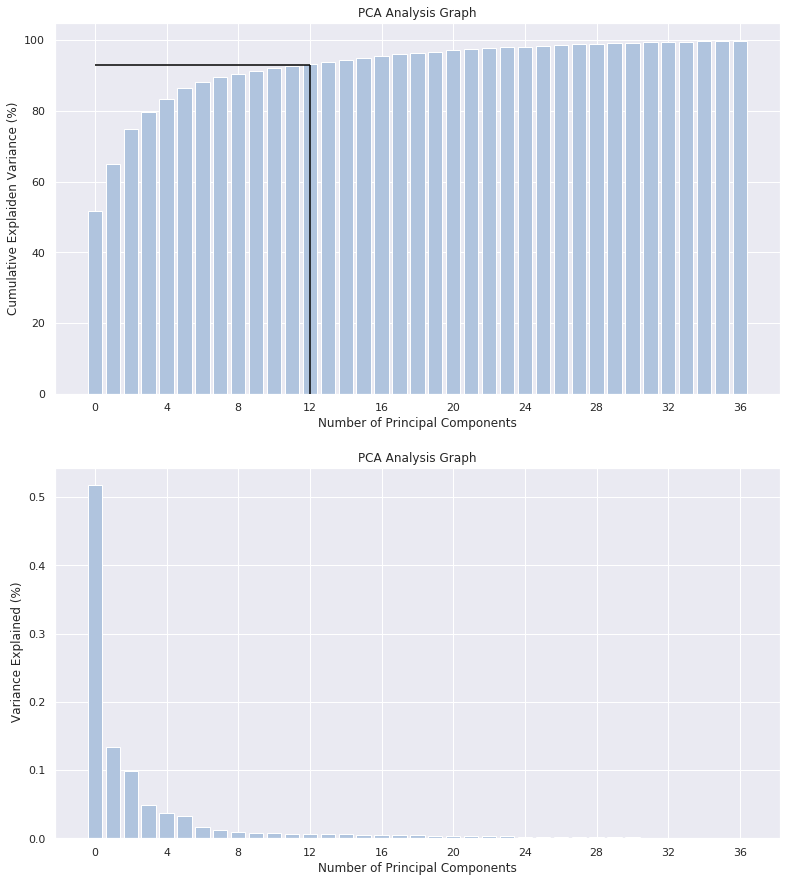

In [51]:
index = np.arange(n_components)
values = pca.explained_variance_ratio_
pca_analysis_plot(n_conponents= n_components, 
             index= index, 
             var_values = values,#
             cum_sum = cumulative_sum_var)

After looking at the variance explained by each component in the screen plots above, I decided to select 12 components, which account for about 93% of the variance explained.

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()

pca_array = pca.fit_transform(df_scaled)
pca_array

## Questão 1

Qual fração da variância consegue ser explicada pelo primeiro componente principal de `fifa`? Responda como um único float (entre 0 e 1) arredondado para três casas decimais.

In [58]:
def q1():
    #return np.round(pca.explained_variance_ratio_[0],3)
    pca = PCA()
    pca_no_norm = pca.fit_transform(df)
    return np.round(pca_no_norm.explained_variance_ratio_[0],3)
    
    

In [59]:
q1()

AttributeError: 'numpy.ndarray' object has no attribute 'explained_variance_ratio_'

## Questão 2

Quantos componentes principais precisamos para explicar 95% da variância total? Responda como un único escalar inteiro.

In [7]:
def q2():
    # Retorne aqui o resultado da questão 2.
    pass

## Questão 3

Qual são as coordenadas (primeiro e segundo componentes principais) do ponto `x` abaixo? O vetor abaixo já está centralizado. Cuidado para __não__ centralizar o vetor novamente (por exemplo, invocando `PCA.transform()` nele). Responda como uma tupla de float arredondados para três casas decimais.

In [8]:
x = [0.87747123,  -1.24990363,  -1.3191255, -36.7341814,
     -35.55091139, -37.29814417, -28.68671182, -30.90902583,
     -42.37100061, -32.17082438, -28.86315326, -22.71193348,
     -38.36945867, -20.61407566, -22.72696734, -25.50360703,
     2.16339005, -27.96657305, -33.46004736,  -5.08943224,
     -30.21994603,   3.68803348, -36.10997302, -30.86899058,
     -22.69827634, -37.95847789, -22.40090313, -30.54859849,
     -26.64827358, -19.28162344, -34.69783578, -34.6614351,
     48.38377664,  47.60840355,  45.76793876,  44.61110193,
     49.28911284
]

In [9]:
def q3():
    # Retorne aqui o resultado da questão 3.
    pass

## Questão 4

Realiza RFE com estimador de regressão linear para selecionar cinco variáveis, eliminando uma a uma. Quais são as variáveis selecionadas? Responda como uma lista de nomes de variáveis.

In [10]:
def q4():
    # Retorne aqui o resultado da questão 4.
    pass